In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

In [2]:
import torchphysics as tp
#import copy
import numpy as np
import torch
import pytorch_lightning as pl
import scipy.io
from scipy.interpolate import griddata
import time
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt


from torchphysics.problem.conditions.condition import DataCondition,  HPCMCondition

/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
np.random.seed(1234)


__Python VERSION: 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
__pyTorch VERSION: 1.13.1
__CUDA VERSION
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [4]:
from scipy.integrate import odeint

In [5]:
def oscillator_state(state, t, delta, alpha, beta, gamma, omega):

    x,vx = state
        
    state_dt = [vx, -delta*vx - alpha*x - beta*x**3 + gamma*np.cos(omega*t)]

    return state_dt

def oscillator_state_linear(state, t, delta, alpha, gamma, omega):

    x,vx = state
    
    state_dt = [vx, -delta*vx - alpha*x + gamma*np.cos(omega*t)]

    return state_dt

In [6]:
delta = 0.3 #1.0 #0.3
omega = 1.2
alpha = -1.0 #-0.1 #-1.0
beta  = 1.0
gamma = 0.2
state0 = [1.0, 0.]
Tp = 2*np.pi/omega
tfinal = 5*Tp   #10.0
dt =  0.01
t_sol =  np.arange(0.0,tfinal+dt,dt)

In [7]:
sol = odeint(oscillator_state, state0, t_sol, args=(delta, alpha, beta, gamma, omega))
sol_tool = odeint(oscillator_state, state0, t_sol, args=(delta+0.5, alpha+0.25, beta + 0.5, gamma, omega)) ##delta+0.1, alpha+0.01, beta + 0.1
sol_linear = odeint(oscillator_state_linear, state0, t_sol, args=(delta, alpha, gamma, omega))

In [8]:
x_state  = sol[:,0]
vx_state = sol[:,1]
x_state_tool = sol_tool[:,0]
vx_state_tool = sol_tool[:,1]
noise = 0.025 # 0.025
x_state_tool = x_state_tool + noise*np.std(x_state_tool)*np.random.randn(len(x_state_tool))
vx_state_tool = vx_state_tool + noise*np.std(vx_state_tool)*np.random.randn(len(vx_state_tool))

x_state_lin= sol_linear[:,0]
vx_state_lin= sol_linear[:,1]


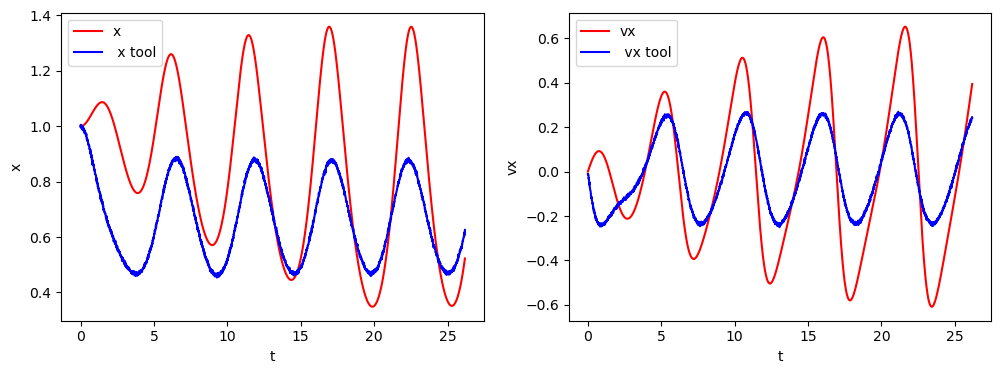

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_sol,x_state,c='r',label='x')
plt.plot(t_sol,x_state_tool,c='b',label=' x tool')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.subplot(122)
plt.plot(t_sol,vx_state,c='r',label='vx')
plt.plot(t_sol,vx_state_tool,c='b',label=' vx tool')
plt.xlabel('t')
plt.ylabel('vx')
plt.legend()
plt.show()


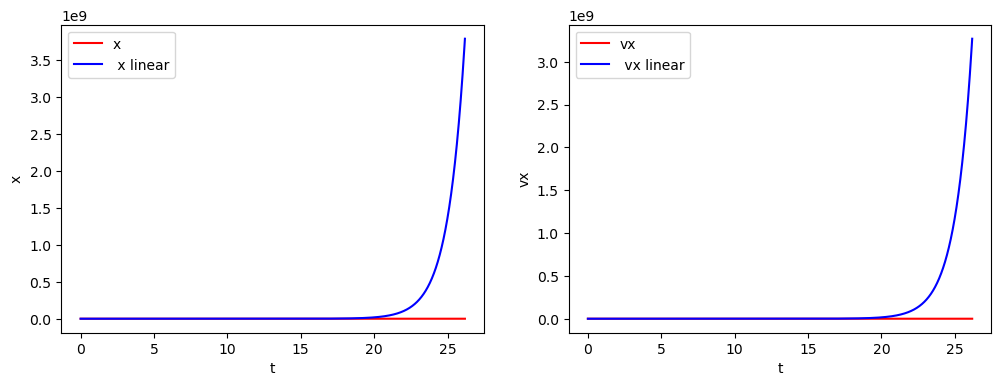

In [10]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_sol,x_state,c='r',label='x')
plt.plot(t_sol,x_state_lin,c='b',label=' x linear')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.subplot(122)
plt.plot(t_sol,vx_state,c='r',label='vx')
plt.plot(t_sol,vx_state_lin,c='b',label=' vx linear')
plt.xlabel('t')
plt.ylabel('vx')
plt.legend()
plt.show()

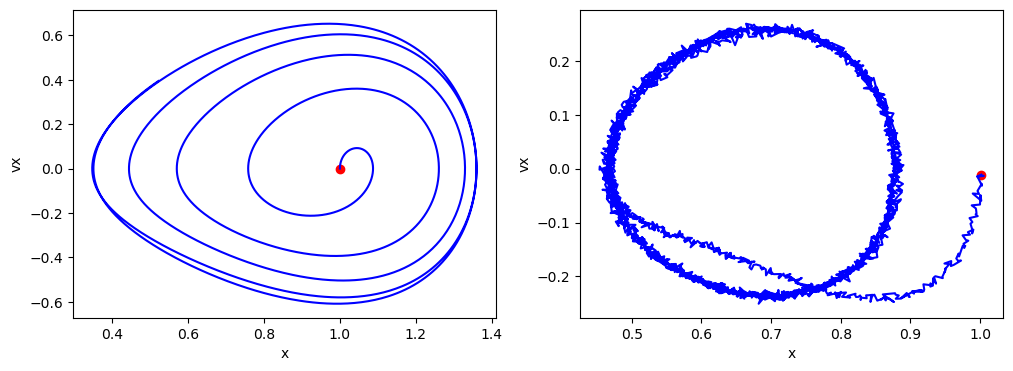

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_state,vx_state,c='b')
plt.scatter(x_state[0],vx_state[0],c='r')
plt.xlabel('x')
plt.ylabel('vx')

plt.subplot(122)
plt.plot(x_state_tool,vx_state_tool,c='b')
plt.scatter(x_state_tool[0],vx_state_tool[0],c='r')
plt.xlabel('x')
plt.ylabel('vx')

plt.show()

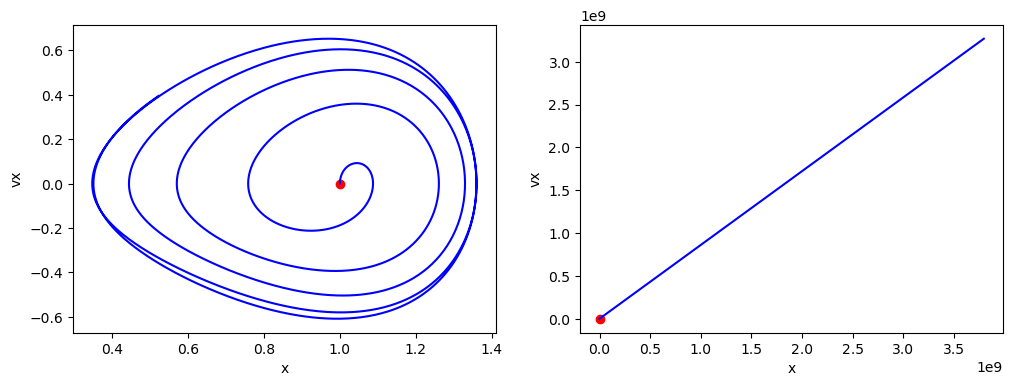

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x_state,vx_state,c='b')
plt.scatter(x_state[0],vx_state[0],c='r')
plt.xlabel('x')
plt.ylabel('vx')

plt.subplot(122)
plt.plot(x_state_lin,vx_state_lin,c='b')
plt.scatter(x_state_lin[0],vx_state_lin[0],c='r')
plt.xlabel('x')
plt.ylabel('vx')

plt.show()

In [13]:
train_data = 100
filter_data = np.random.choice(len(t_sol), train_data, replace=False)


train_data_tool = 100

same_data_tool = True

if same_data_tool:
    filter_data_tool = filter_data
else:
    filter_data_tool = np.random.choice(len(t_sol), train_data_tool, replace=False)



In [14]:
print('train data percent: ', len(filter_data)*100.0/len(t_sol), '%')
print('train data tool percent: ', len(filter_data_tool)*100.0/len(t_sol), '%')


train data percent:  3.8182512409316534 %
train data tool percent:  3.8182512409316534 %


In [37]:
t_tensor = torch.tensor(t_sol,dtype=torch.float32)
x_tensor = torch.tensor(x_state,dtype=torch.float32)
vx_tensor = torch.tensor(vx_state,dtype=torch.float32)

t_tool_tensor = torch.tensor(t_sol,dtype=torch.float32)
x_tool_tensor = torch.tensor(x_state_tool,dtype=torch.float32)
vx_tool_tensor = torch.tensor(vx_state_tool,dtype=torch.float32)

t_lin_tensor = torch.tensor(t_sol,dtype=torch.float32)
x_lin_tensor = torch.tensor(x_state_lin,dtype=torch.float32)
vx_lin_tensor = torch.tensor(vx_state_lin,dtype=torch.float32)



In [38]:
t_tensor_train = t_tensor[filter_data]
x_tensor_train = x_tensor[filter_data]
vx_tensor_train = vx_tensor[filter_data]
t_tool_tensor_train = t_tool_tensor[filter_data_tool]
x_tool_tensor_train = x_tool_tensor[filter_data_tool]
vx_tool_tensor_train = vx_tool_tensor[filter_data_tool]

t_lin_tensor_train = t_lin_tensor[filter_data_tool]
x_lin_tensor_train = x_lin_tensor[filter_data_tool]
vx_lin_tensor_train = vx_lin_tensor[filter_data_tool]



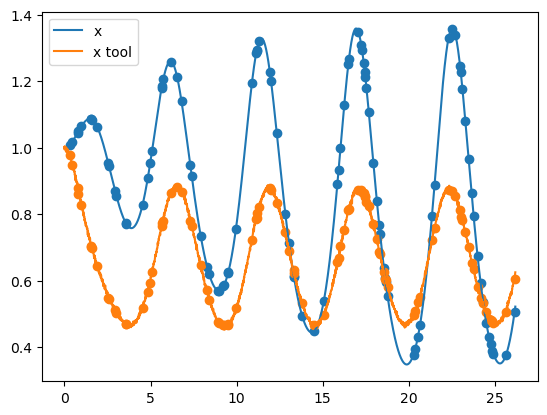

In [39]:
plt.figure()
plt.scatter(t_tensor_train.flatten(),x_tensor_train.flatten())
plt.plot(t_tensor.flatten(),x_tensor.flatten(),label='x')
plt.scatter(t_tool_tensor_train.flatten(),x_tool_tensor_train.flatten())
plt.plot(t_tool_tensor.flatten(),x_tool_tensor.flatten(),label='x tool')
plt.legend()
plt.show()

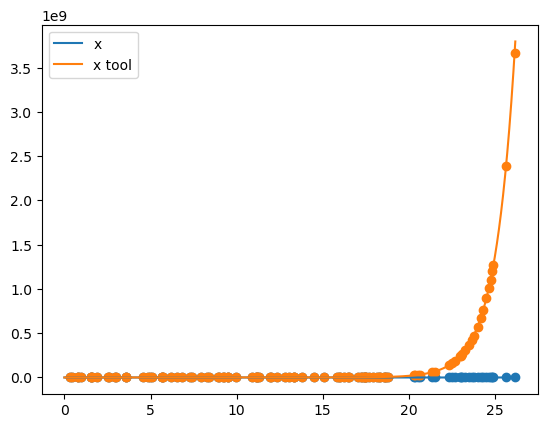

In [40]:
plt.figure()
plt.scatter(t_tensor_train.flatten(),x_tensor_train.flatten())
plt.plot(t_tensor.flatten(),x_tensor.flatten(),label='x')
plt.scatter(t_lin_tensor_train.flatten(),x_lin_tensor_train.flatten())
plt.plot(t_lin_tensor.flatten(),x_lin_tensor.flatten(),label='x tool')
plt.legend()
plt.show()

In [18]:
T = tp.spaces.R1('t') # input space (t)
STATE = tp.spaces.R2('state') 
X = tp.spaces.R1('x')
VX = tp.spaces.R1('vx')
X2 = tp.spaces.R1('x2')
VX2 = tp.spaces.R1('vx2')
T2 = tp.spaces.R1('t2')
CORR = tp.spaces.R2('corr')

In [19]:
I     = tp.domains.Interval(space=T, lower_bound=t_sol.min(), upper_bound=t_sol.max())

In [20]:
normalization_layer = tp.models.NormalizationLayer(I)
fcn_layer           = tp.models.FCN(input_space=T, output_space=STATE, hidden = (100,100,100))

In [21]:
model_state = tp.models.Sequential(normalization_layer, fcn_layer)

In [22]:
input_data_train = tp.spaces.Points(torch.column_stack([t_tensor_train]), T,device='cuda')
output_data_train = tp.spaces.Points(torch.column_stack([x_tensor_train,vx_tensor_train]),STATE,device='cuda')

input_data_tool_train = tp.spaces.Points(torch.column_stack([t_tool_tensor_train]), T,device='cuda')
output_data_tool_train = tp.spaces.Points(torch.column_stack([x_tool_tensor_train,vx_tool_tensor_train]),STATE,device='cuda')


In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
data_loader = tp.utils.PointsDataLoader((input_data_train, output_data_train), batch_size=len(input_data_train),
                                                                  shuffle  = False,
                                                                  pin_memory = True)


data_condition  = DataCondition(module=model_state,dataloader=data_loader,
                                                        norm=2,
                                                        use_full_dataset=True,
                                                        name="Data_Condition",
                                                        weight = 1)
                                                        

In [25]:
fcn_layer_corr          = tp.models.FCN(input_space=T*T2*X*X2*VX*VX2, output_space= CORR, hidden = (100,100))
model_corr           = tp.models.Sequential(fcn_layer_corr)

In [26]:
data_tool_loader = tp.utils.PointsDataLoader((input_data_tool_train, output_data_tool_train), batch_size=len(input_data_tool_train),
                                                                  shuffle  = False,
                                                                  pin_memory = True)

In [1]:
def correction_func(t,state):
    
    x, vx = state[:,0:1], state[:,1:2]
   
    model_corr_inp = tp.spaces.Points(torch.column_stack((t,t**2,x,x**2,vx,vx**2)), T*T2*X*X2*VX*VX2) #, device = 'cuda')
    
    corr = model_corr(model_corr_inp)


    return corr #res



In [28]:
hpcm_condition =  HPCMCondition(module_state = model_state, module_corr = model_corr, dataloader_corr = data_tool_loader ,correction_fn =  correction_func)


In [29]:
training_conditions = [data_condition,hpcm_condition]
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001)
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

In [30]:
# Start the training
trainer = pl.Trainer(gpus=1, max_steps=10000, logger=True,benchmark=True)

trainer.fit(solver) # start training


/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 31.6 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
31.6 K    Trainable params
0         Non-trainable params
31.6 K    Total params
0.126     Total estimated model params size (MB)


/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/ibp5kor/.conda/envs/torchphysics/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0: 100%|█████████▉| 10000/10001 [01:23<00:00, 119.60it/s, loss=0.000163, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 10001/10001 [01:23<00:00, 119.60it/s, loss=0.000163, v_num=16]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10001/10001 [01:23<00:00, 119.58it/s, loss=0.000163, v_num=16]


In [31]:
input_data_test = tp.spaces.Points(torch.column_stack([t_tensor]), T,device='cpu')

In [32]:
def model_state_output(t):
    out = model_state(tp.spaces.Points(t, T,device='cpu')).as_tensor.detach().numpy()
    x = out[:,0:1]
    vx  = out[:,1:2]
    return x, vx
    

    
def model_correction_output(t):
    
    state = model_state(tp.spaces.Points(t, T,device='cpu'))
    
    state = state.as_tensor  
    
    x, vx = state[:,0:1], state[:,1:2]
        
    model_corr_inp = tp.spaces.Points(torch.column_stack((t,t**2,x,x**2,vx,vx**2)), T*T2*X*X2*VX*VX2) #, device = 'cuda')
    
    corr = model_corr(model_corr_inp)
    
    corr = corr.as_tensor.detach().numpy()
    
    x_corr = corr[:,0:1]
    vx_corr = corr[:,1:2]
    
    return x_corr, vx_corr


In [33]:
def L2_ERROR(true_val,pred_val):
    
    return np.linalg.norm(true_val-pred_val,2)/np.linalg.norm(true_val,2)

def R2_SCORE(true_val,pred_val):
    
    mean_true = np.mean(true_val)
    
    return 1.0 - np.mean(np.square(true_val-pred_val))/np.mean(np.square(true_val-mean_true))


In [34]:
x_state_pred, vx_state_pred =  model_state_output(t_tensor.reshape(-1,1))
x_corr_pred, vx_corr_pred =  model_correction_output(t_tool_tensor.reshape(-1,1))

x_state_with_corr = x_corr_pred  + x_tool_tensor.reshape(-1,1).numpy()
vx_state_with_corr = vx_corr_pred  + vx_tool_tensor.reshape(-1,1).numpy()

In [35]:
error_pred_x =  L2_ERROR(x_state.flatten(),x_state_pred.flatten())
error_pred_vx =  L2_ERROR(vx_state.flatten(),vx_state_pred.flatten())
error_pred_x_with_corr = L2_ERROR(x_state.flatten(),x_state_with_corr.flatten())
error_pred_vx_with_corr = L2_ERROR(vx_state.flatten(),vx_state_with_corr.flatten())

print('L2 Error x: ',error_pred_x)
print('L2 Error vx: ',error_pred_vx)
print('L2 Error x with correction: ',error_pred_x_with_corr)
print('L2 Error vx with correction: ',error_pred_vx_with_corr)


L2 Error x:  0.006969126936745646
L2 Error vx:  0.014264306638195374
L2 Error x with correction:  0.011467449079765421
L2 Error vx with correction:  0.031875107550631214


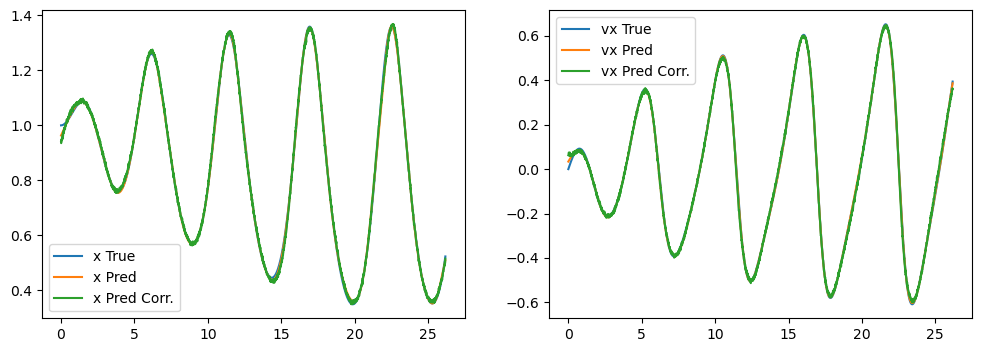

In [36]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t_sol.flatten(),x_state.flatten(),label='x True')
plt.plot(t_sol.flatten(),x_state_pred.flatten(),label='x Pred')
plt.plot(t_sol.flatten(),x_state_with_corr.flatten(),label='x Pred Corr.')
plt.legend()

plt.subplot(122)
plt.plot(t_sol.flatten(),vx_state.flatten(),label='vx True')
plt.plot(t_sol.flatten(),vx_state_pred.flatten(),label='vx Pred')
plt.plot(t_sol.flatten(),vx_state_with_corr.flatten(),label='vx Pred Corr.')
plt.legend()
plt.show()